In [6]:
# Import packages
import numpy as np                                                                                  # For data manipulation 
import tensorflow as tf                                                                             # For building the model
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data
import os                                                                                           # For setting environment variables

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [7]:
# variables

PLOT_SIZE = (8, 8)
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#FF8C00', '#006400']
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
MODEL_NAME = 'NDVI_CNN_V1.keras'
MODEL_PATH = 'saved_data/' + MODEL_NAME
IMAGE_PATH = 'ndvi_data/Landsat_Wonosobo_2023.tif'

In [8]:
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print('Model loaded successfully')
except:
    print('Model not found')

Model loaded successfully


In [9]:
# Function to reshape array input
def reshape_input(array):
    return np.expand_dims(array, axis=-1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


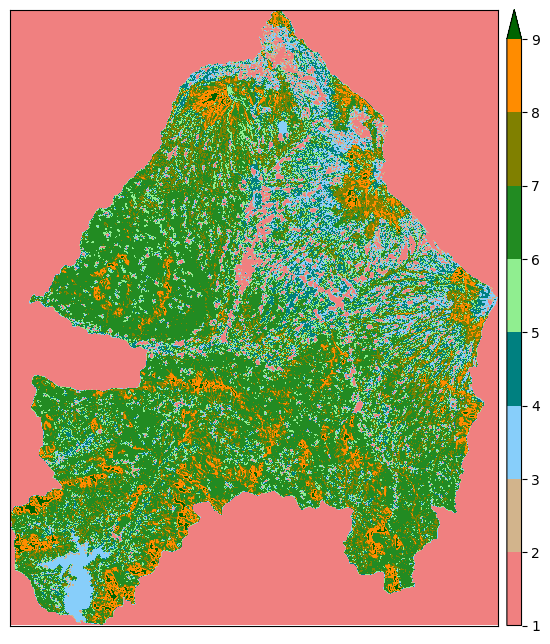

<Axes: >

In [10]:
image = rasterio.open(IMAGE_PATH)

bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_input = []
used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
for i in used_image_feature:
  image_input.append(image.read(i))
image_input = reshape_input(np.stack(image_input).reshape(NUM_OF_BANDS, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction + 1, cmap=cmap, norm=norm, figsize=PLOT_SIZE)

In [11]:
# Save file to drive
save_location = 'saved_data/'
name = 'Output.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1)
new_dataset.close()